# Extraction of Exponential-Integrate-and-Fire Models From Blue Brain Project Cells

In [1]:
## import the required modules 
from neuron import h
import numpy as np
from scipy.optimize import curve_fit
import warnings
from matplotlib import pyplot as plt

### Loading Data of Requested Cell Type

In [2]:
## load the output data from simulation of the BBP cell of interest.
## Simulations of each neuron are held according to experimental process explained in (Badel et al., 2008) 
## with 8 types of noisy input (Ornstein-Uhlenbeck process). Experiment array containing V_mem, I_inj, t, dV/dt and
## spike times are stored in .npy files. In silico experimentation of BBP cells on Python requires NEURON and file of the cells, 
## thus, this part isn't shown in this Notebook. To see the methods to generate the experimental process of EIF extraction
## on BBP cells, see https://github.com/oykur > EIF Extraction Kit
warnings.filterwarnings("ignore")                         ## due to infinities in the calculation of capacitance, some warnings that occur can be made invisible
cell_type = input("Write the cell type of interest among: STPC, TTPC2, UTPC: ") ## More cell types will be added soon...
print(cell_type + " is selected.")
spiketimes = np.load(cell_type+"_spiketimes.npy")         ## load the spike times obtained by patch-clamping a BBP neuron with 8 types of Ornstein-Uhlenbeck Process
experiment_array = np.load(cell_type+"_exp_array.npy")    ## experiment output is stored in an array, contains membrane potential (V_mem), injected current (I_inj), time (t), and potential change over time (dV/dt) respectively.
print("Next step may take few minutes.")

Write the cell type of interest among: STPC, TTPC2, UTPC: STPC
STPC is selected.
Next step may take few minutes.


### Filtering the 200 ms After Each Spike From the Data

In [3]:
dt = 0.025                                          ## ms - Integration time step. 

V_maxes = np.array([])                              ## array to store the maximum points of action potentials (AP)
V_maxes_ind = np.array([])                          ## array to store the indexes of maximum points

V_s = int(spiketimes[0])                            ## time of the first spike 
V_s_index = np.argmax(experiment_array[2,:] > V_s)  ## index of the time point of V_s in the experiment array
V_s_plus = (np.argmax(experiment_array[0][V_s_index:(V_s_index+100)])) ## V_max should be V_s_plus elements after the V_s_index
V_max = V_s_plus*0.025+ V_s                         ## find the time point of the peak of spike
V_maxes = np.append(V_maxes, V_max)                 ## store time of the peak
V_max_array_ind = int(V_s_index+V_s_plus)           ## find index of the peak in the experiment array
V_max_last_ind = V_max_array_ind                    ## to be used in filtering, store this spike as the last spike
V_last_spike = V_s

not_keeping_next = 0 ## if there are one or more spikes in the 200 ms after a spike, in the interval that will be filtered, 
                     ## the last spike in this interval should be found and filtering should be from peak of the first spike to 
                     ## 200 ms after the last spike. Thus, if the current spike is still in the 200 ms interval, not_keeping_next = 1
                     ## and it is changed back to 0 when the filtering is completed with the last spike of the interval. 
spike = 1            ## start from the second spike
print("Filtering process is starting...")
while spike < len(spiketimes):                      ## till the end of the spikes, continue filtering
    V_s = int(spiketimes[spike]) 
    V_s_index = np.argmax(experiment_array[2,:] > V_s) 
    V_s_plus = (np.argmax(experiment_array[0][V_s_index:(V_s_index+100)]))
    V_max = V_s_plus*0.025+ V_s                     ## use V_s to find where AP has peaked
    V_maxes = np.append(V_maxes, V_max)
    V_max_array_ind = int(V_s_index+V_s_plus)

    if V_last_spike + 200 >= V_s and not_keeping_next ==0:
        #print("This is the "+str(spike)+"th spike. We will skip that.")
        V_old = V_last_spike                        ## store the first spike in the 200 ms period as the old spike
        V_old_ind = V_max_last_ind  
        not_keeping_next = 1                        ## this spike will not be filtered, yet
        spike += 1                                  ## continue with the next spike
    elif V_last_spike + 200 >= V_s and not_keeping_next ==1:     ## current spike is still in the 200 ms period, no filtering, skip this spike
        #print("This is the "+str(spike)+"th spike. We will skip that.")
        spike += 1
    elif V_last_spike + 200 < V_s and not_keeping_next ==1:      ## current spike is out of the 200 ms period, filtering step
        V_max_last_200 = (V_max_last_ind+int(200/dt))            ## 200 ms after the last spike
        delete_range = np.arange(V_old_ind, V_max_last_200+1,1)  ## delete from max. of old spike to the 200 ms after the max. of the last spike
        experiment_array = np.delete(experiment_array, delete_range,1)   
        V_maxes_ind = np.append(V_maxes_ind, V_old_ind)          ## since the index of current spike is changed, store the new index
        V_s_index = np.argmax(experiment_array[2,:] > V_s)
        V_s_plus = (np.argmax(experiment_array[0][V_s_index:(V_s_index+100)]))
        V_max_array_ind = int(V_s_index+V_s_plus)        
        not_keeping_next = 0                                     ## go back to 0 since this 200 ms interval is completed
        #print("This is the "+str(spike)+"th spike. Finally filtered.")
        spike += 1
    elif V_last_spike + 200 < V_s and not_keeping_next ==0:      ## there aren't any extra spikes in the 200 ms period, filter directly
        V_max_last_200 = (V_max_last_ind+int(200/dt))    
        delete_range = np.arange(V_max_last_ind, V_max_last_200+1,1) 
        experiment_array = np.delete(experiment_array, delete_range,1) 
        V_maxes_ind = np.append(V_maxes_ind, V_max_last_ind)
        V_s_index = np.argmax(experiment_array[2,:] > V_s)
        V_s_plus = (np.argmax(experiment_array[0][V_s_index:(V_s_index+100)]))
        V_max_array_ind = int(V_s_index+V_s_plus) 
         #print("This is the "+str(spike)+"th spike. Filtered.")
        spike += 1
    V_max_last_ind = V_max_array_ind                             ## always store the last spike since it can be used in the next filtering
    V_last_spike = V_s
if not_keeping_next==1:                                          ## sometimes there are a lot of spike in the very last 200 ms 
    V_max_last_200 = (V_max_last_ind+int(200/dt))                ## and loop is completed without them filtered, these lines are to filter them if this is the case 
    delete_range = np.arange(V_old_ind, V_max_last_200+1,1)
    experiment_array = np.delete(experiment_array, delete_range,1) 
    print("This is the last spike. Filtering is completed.")

Filtering process is starting...
This is the last spike. Filtering is completed.


### Calculation of Capacitance With Variance Minimization Method

In [4]:
experiment_array = experiment_array.T[np.argsort(experiment_array.T[:, 0])]  ## sort the array by increasing values of membrane potential
experiment_array_2 = experiment_array[(experiment_array[:,0] < -60)]         ## store subthreshold data into another array
C_e = np.arange(0,1,0.005)                                ## nF, estimate capacitance (C_e), candidates to be the capacitance (C), each one is used to calculate corresponding varience
                                                          ## as the increment (0.005 nF) gets smaller, accuracy of C increases
var_list = np.array([])                                   ## store the variances in an array to find the minimum
ce = 0
while ce < np.size(C_e):                         
    inj_ce = experiment_array_2[:,1]/C_e[ce]              ## to find [I_inj/C-dVdt], I_inj/C_e values put in a vector
    difference = inj_ce - experiment_array_2[:,3]         ## [I_inj/C-dVdt] values for the current C_e is found
    var_list = np.hstack((var_list,np.var(difference)))   ## var[I_inj/C-dVdt] is calculated and stored 
    ce += 1                                               ## continue with the next C_e
C_e = C_e[~np.isnan(var_list)]                            
var_list = var_list[~np.isnan(var_list)]
minimum = np.argmin(var_list)                             ## find where is the minimum of variance
C = C_e[minimum] *1000
print("Capacitance of cell is " + str(C)+ " pF")

Capacitance of cell is 295.0 pF


Text(0.5, 0, '$C_e$ (nF)')

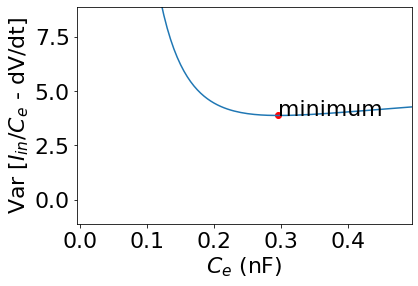

In [5]:
## plot the variance calculated for each C_e. Graph is magnified to show the minimum point. 
plt.figure()
plt.rcParams["figure.figsize"] = (13,7)
plt.rcParams.update({'font.size': 22})
plt.plot(C_e, var_list)
plt.ylim(min(var_list)-5,min(var_list)+5)
plt.xlim(C_e[minimum]-0.3,C_e[minimum]+0.2)
plt.scatter(C_e[minimum], var_list[minimum], color="red", )
plt.annotate("minimum", (C_e[minimum], var_list[minimum]))
plt.ylabel("Var [$I_{in}$/$C_e$ - dV/dt]")
plt.xlabel('$C_e$ (nF)')
#plt.savefig("find_c.png")

### Calculation of Transmembrane Current (I<sub>m</sub>) and Mean of I<sub>m</sub> in Small Voltage Intervals (I<sub>d</sub>)

In [6]:
experiment_array_2 = experiment_array[(experiment_array[:,0] > -105) & (experiment_array[:,0] < -45)]

inj_pA = experiment_array_2[:,1]*1000              ## I_inj converted from nA to pA
dvdt_C = experiment_array_2[:,3]*C                 ## For calculating I_ion = I_inj - dvdt*C
I_ion = inj_pA - dvdt_C                            ## Transmembrane current is calculated
experiment_array_2 = np.column_stack((experiment_array_2, I_ion))  ## add I_ion to the dataframe
interval_dictionary = {"STPC": [-105,-50], "UTPC": [-105, -47], "TTPC2": [-105,-48]} ## best EIF fits for these cells are found in these specific voltage intervals
interval_V = interval_dictionary[cell_type]     
I_d = np.array([]) ## store I_d values, found by formula I_d = <I_m> (mean of I_m for little intervals such as V-0.5 mV to V+0.5 mV)
min_max_range = np.arange(interval_V[0], interval_V[1], 0.5)  ## from min to max, every V_m value with increment 0.5 mV
i = 0
while i < len(min_max_range)-1:
    V_interval = experiment_array_2[(experiment_array_2[:,0] > min_max_range[i]) & (experiment_array_2[:,0] < min_max_range[i+1])]
                                                   ## V_m values in the interval V-0.5 mV to V+0.5mV
    I_d = np.append(I_d, np.mean(V_interval[:,4])) ## mean of the interval is found and added as a point of I_d
    i += 1
range_V = np.arange((interval_V[0]+0.25), (interval_V[1]-0.25), 0.5) ## points of means
range_V = range_V[~np.isnan(I_d)]
I_d = I_d[~np.isnan(I_d)]

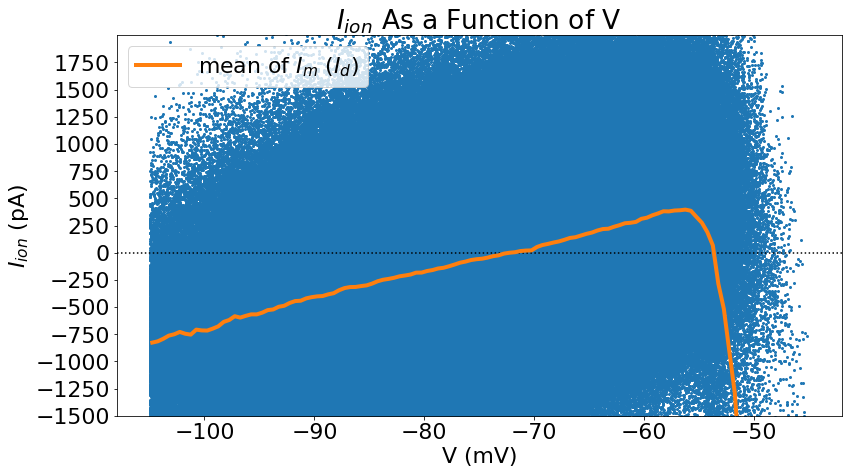

In [7]:
## plot I_m-V and I_d-V graphs together 
plt.figure() 
plt.plot(experiment_array_2[:,0], experiment_array_2[:,4], 'o', markersize = 2)
plt.yticks(np.arange(-1500, 2000, 250))
plt.ylim(-1500,2000)
plt.axhline(y=0, color='k', linestyle='dotted')
plt.plot(range_V, I_d, linewidth=4.0, label = "mean of $I_m$ ($I_d$)")
plt.title("$I_{ion}$ As a Function of V")
plt.xlabel('V (mV)')
plt.ylabel("$I_{ion}$ (pA)")
plt.legend()
plt.show()
# plt.savefig("Iion.png")

### Calculation of Function of Voltage (F(V)) and Finding the Parameters for the EIF Model

In [8]:
F_actual = -I_d/C                   ## F(V) = -I_d/C from the article, find each F value for V_m's
## EIF model is fit on the F_actual with curve_fit()
popt, pcov = curve_fit(lambda V, tau, E_m, Vt, delta_t: (1/tau)*(E_m - V + delta_t * np.exp((V-Vt)/delta_t)),  np.array(range_V),  np.array(F_actual).flatten(),p0 = [10,-72,-55,1.5])
tau, E_m, Vt, delta_t = popt        ## parameters are saved
    
F_fit = (1/tau)*(E_m-range_V+delta_t*np.exp((range_V - Vt)/delta_t)) ## Find each F_fit value for V_m's

## Calculating r_square of the fit
F_array = np.array(F_actual)
F_array = np.reshape(F_array, (len(F_array),))
F_fit_array = np.array(F_fit)

sum1 = sum((F_array - F_fit_array)**2)
sum2 = sum((F_array - np.mean(F_fit_array))**2)
r_sq = 1 - (sum1/sum2)

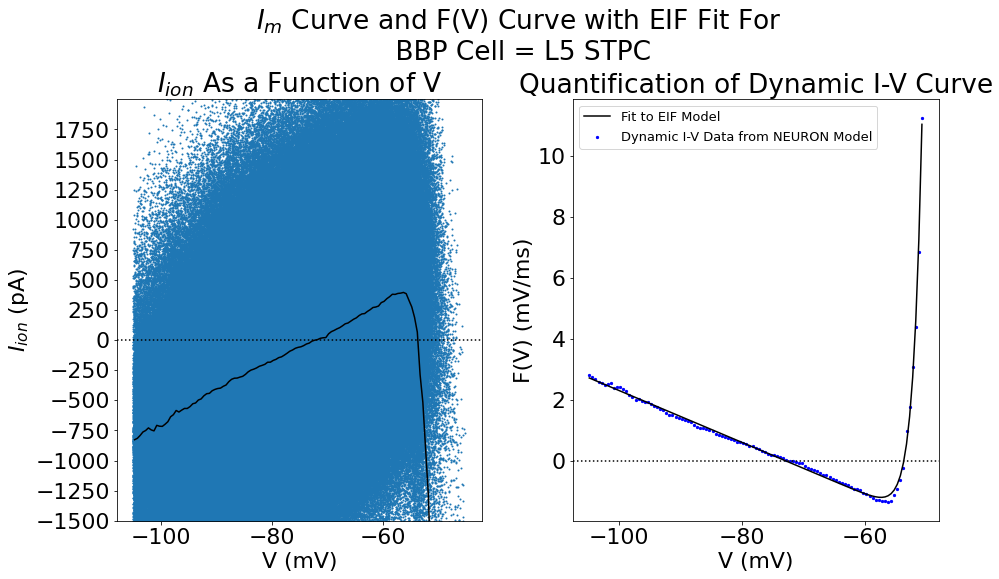

In [9]:
## plot the I_m-V and I_d-V, together with F(V)-V and EIF Fit-V
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.suptitle("$I_m$ Curve and F(V) Curve with EIF Fit For \n BBP Cell = L5 " + cell_type, y=1.12)
ax1.plot(experiment_array_2[:,0], experiment_array_2[:,4], 'o', markersize = 1)
ax1.plot(range_V, I_d,linestyle='-', color='k')
ax1.set_yticks(np.arange(-1500, 2000, 250))
ax1.set_ylim(-1500,2000)
ax1.axhline(y=0, color='k', linestyle='dotted')
ax1.set_title("$I_{ion}$ As a Function of V")
ax1.set_xlabel('V (mV)')
ax1.set_ylabel("$I_{ion}$ (pA)")
ax2.scatter(range_V,F_actual, marker='o', color='b', label="Dynamic I-V Data from NEURON Model", s=5)
ax2.plot(range_V,F_fit, linestyle='-', color='k', label="Fit to EIF Model")
ax2.set_title("Quantification of Dynamic I-V Curve")
ax2.axhline(y=0, color='k', linestyle='dotted')
ax2.set_xlabel("V (mV)")
ax2.set_ylabel("F(V) (mV/ms)")
plt.legend(fontsize=13)
plt.show()

In [10]:
print("Experiment with 8 types of OU input, each input injected for 40 seconds to the BBP cell "+ str(cell_type) )
print("Results are:\n Capacitance = "+str(C)+ " pF"
            ",\n Parameters of the fit: \n tau= "+str(popt[0])+" ms, \n V_rest= " + str(popt[1])+" mV, \n V_thres= "+str(popt[2])+" mV, \n delta_t= "+ str(popt[3])+" mV")
print("Error of the fit is "+str(r_sq)+ " and error for parameters: " + str(np.diag(pcov)))

Experiment with 8 types of OU input, each input injected for 40 seconds to the BBP cell STPC
Results are:
 Capacitance = 295.0 pF,
 Parameters of the fit: 
 tau= 11.72597222970027 ms, 
 V_rest= -72.92390445967213 mV, 
 V_thres= -57.3873046939756 mV, 
 delta_t= 1.4213873424406631 mV
Error of the fit is 0.9960381215177029 and error for parameters: [0.0117754  0.02204499 0.00401067 0.00038499]
